# NLP Datasets

A brief overview and look at the NLP datasets we'll be using in developing and evaluating this integration package

NLP – Natural Language Processing \
NLU – Natural Language Understanding \
NLG – Natural Language Generation

In [ ]:
import json, csv
from pathlib import Path

import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

import nlp, torch
from transformers import *

pd.set_option('display.max_colwidth', 500)

## Task - Language Modeling

"Language modeling is the task of fitting a model to a corpus, which can be domain specific. All popular transformer based models are trained using a variant of language modeling, e.g. BERT with masked language modeling, GPT-2 with causal language modeling."

"Language modeling can be useful outside of pre-training as well, for example to shift the model distribution to be domain-specific: using a language model trained over a very large corpus, and then fine-tuning it to a news dataset or on scientific papers e.g. LysandreJik/arxiv-nlp."

**Masked Language Modeling (MLM)**: "Masked language modeling is the task of masking tokens in a sequence with a masking token, and prompting the model to fill that mask with an appropriate token. This allows the model to attend to both the right context (tokens on the right of the mask) and the left context (tokens on the left of the mask). Such a training creates a strong basis for downstream tasks requiring bi-directional context such as SQuAD (question answering, see Lewis, Lui, Goyal et al., part 4.2)."

**Causal language modeling**: "is the task of predicting the token following a sequence of tokens. In this situation, the model only attends to the left context (tokens on the left of the mask). Such a training is particularly interesting for generation tasks."

You can "leverage the `generate()` method to generate the tokens following the initial sequence"
```
input = tokenizer.encode(sequence, return_tensors="pt")
generated = model.generate(input, max_length=50, do_sample=True)
```

### WikiText-103

**Objective**: Predict the next work or the masked token

In [ ]:
LM_PATH = Path('./data/task-language-modeling')

In [ ]:
raw_data = nlp.load_dataset('wikitext')
raw_data.keys()

In [ ]:
train_df = pd.DataFrame(raw_data['train'])
valid_df = pd.DataFrame(raw_data['validation'])
test_df = pd.DataFrame(raw_data['test'])

train_df['ds_type'] = 'train'
valid_df['ds_type'] = 'valid'
test_df['ds_type'] = 'test'

joined_df = pd.concat([train_df, valid_df, test_df])

In [ ]:
display(joined_df.head())
print(len(joined_df))

In [ ]:
joined_df.to_csv(LM_PATH/'wiki103_cleaned.csv', index=None)
joined_df[:1000].to_csv('./wiki103_sample.csv', index=None)

## Task - Sequence Classification

**Sequence classification**: is the task of classifying sequences according to a given number of classes. An example of sequence classification is the GLUE dataset, which is entirely based on that task. If you would like to fine-tune a model on a GLUE sequence classification task, you may leverage the run_glue.py or run_tf_glue.py scripts.

### GLUE

See https://gluebenchmark.com/tasks

The General Language Understanding Evaluation (GLUE) benchmark is a collection of nine sentence- or sentence-pair language understanding tasks for evaluating and analyzing natural language understanding systems.

**Objective**: sequence classification

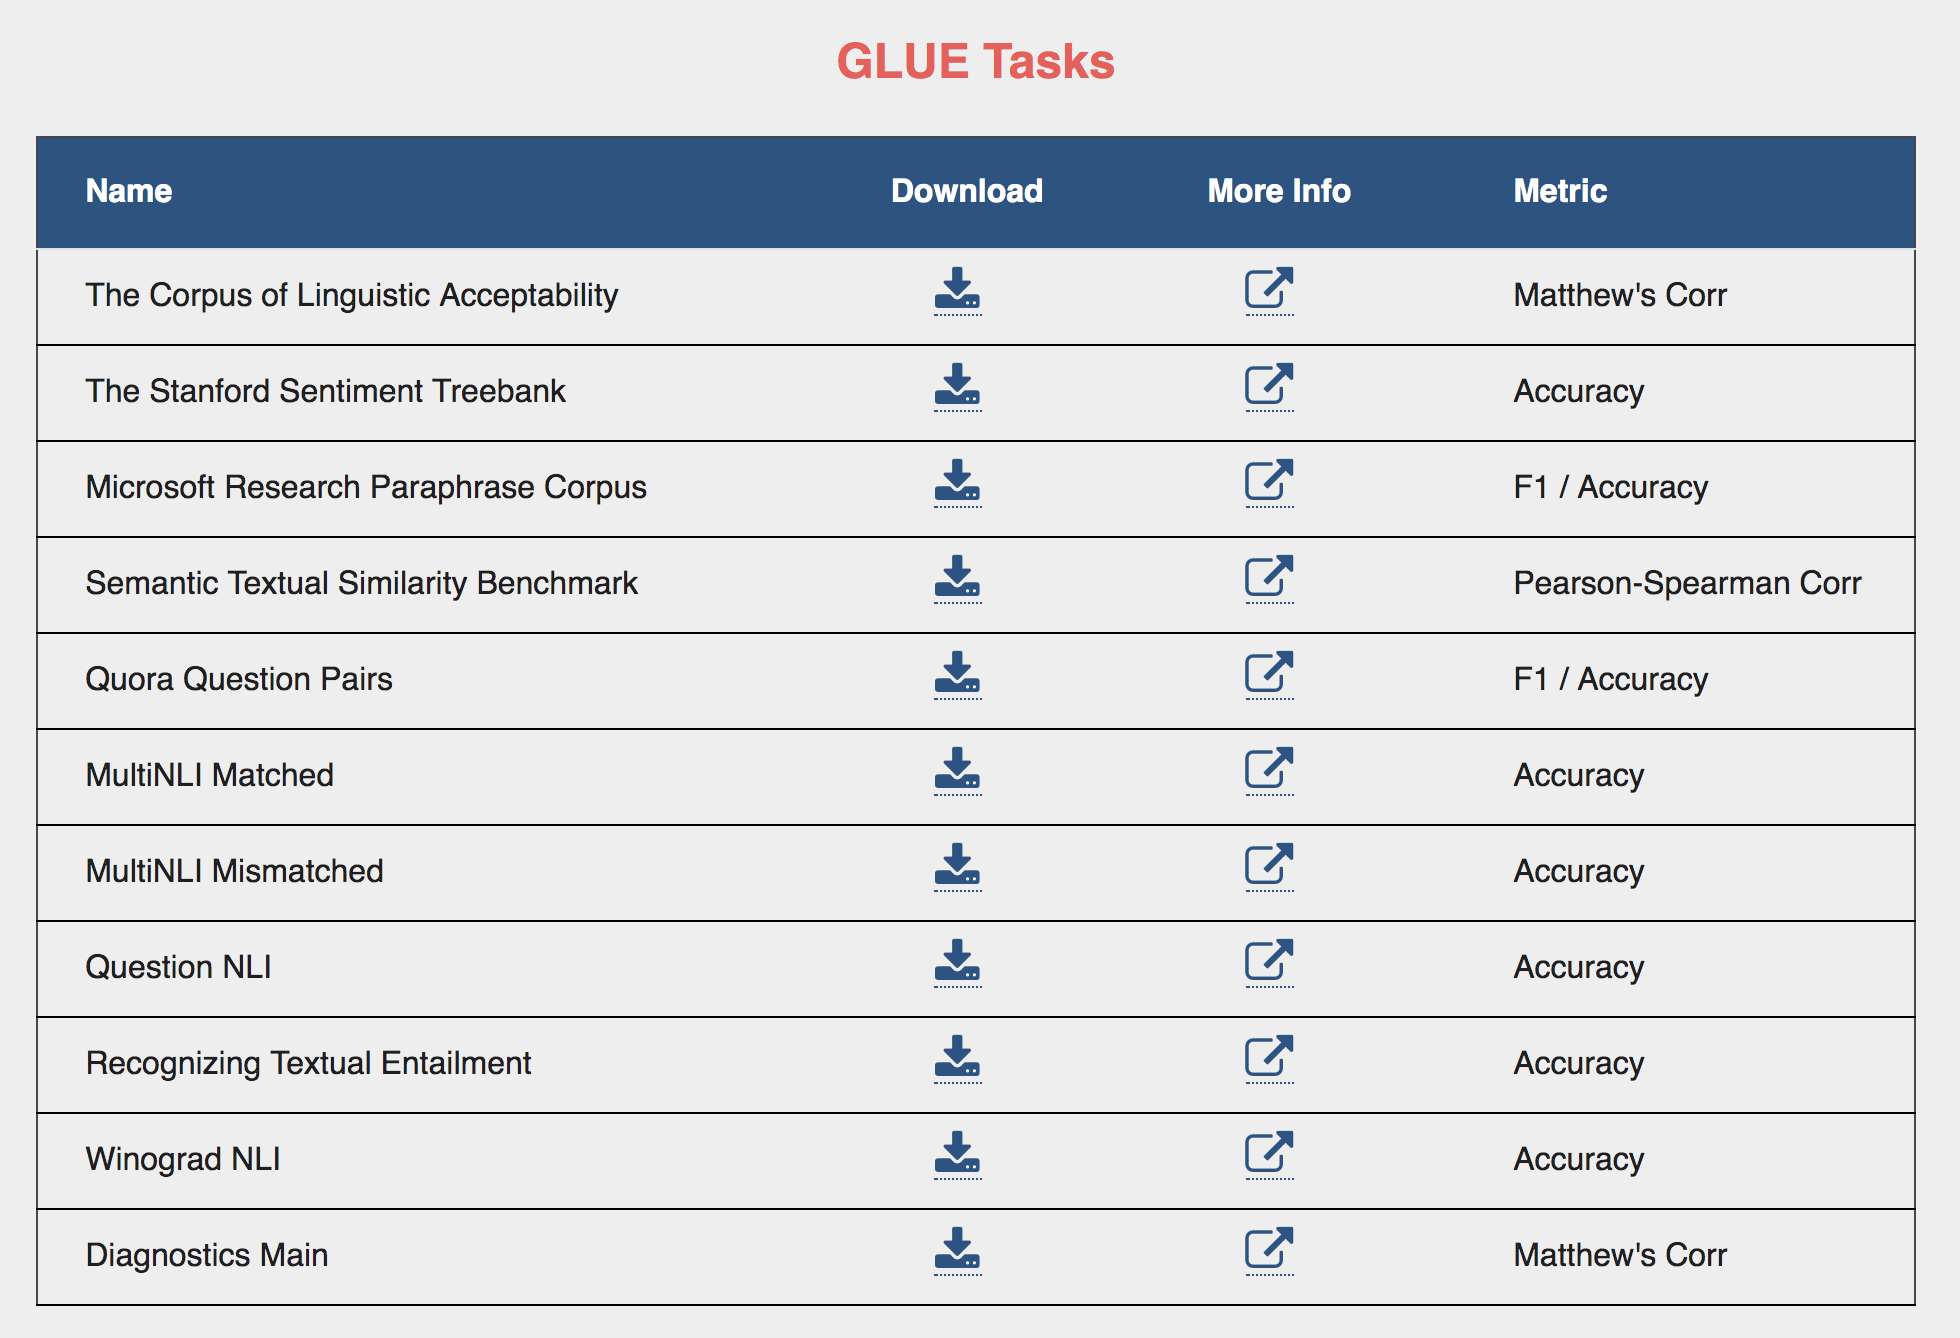

In [ ]:
GLUE_PATH = Path('./data/task-sequence-classification/glue')

#### CoLA

**Objective**: Grammatical acceptability of a sentence (0 = Unacceptable, 1 = Acceptable)

https://nyu-mll.github.io/CoLA/

10,657 examples

Human Performance: "Average accuracy across annotators is 86.1%, and average Matthews correlation coefficient (MCC)7 is 0.697"

"Matthews correlation coefficient (Matthews, 1975) is our primary classification performance metric. It measures correlation on unbalanced binary classification tasks in range from -1 to 1, with any uninformed random guessing achieving an expected score of 0."

"When examples appear with non-binary judgments (less than 3%), we either exclude them (for labels ‘?’ or ‘#’), or label them unacceptable (‘??’ and ‘*?’)."

In [ ]:
raw_data = nlp.load_dataset('glue')
raw_data.keys()

In [ ]:
train_df = pd.DataFrame(raw_data['train'])
valid_df = pd.DataFrame(raw_data['validation'])
test_df = pd.DataFrame(raw_data['test'])

train_df['ds_type'] = 'train'
valid_df['ds_type'] = 'valid'
test_df['ds_type'] = 'test'

joined_df = pd.concat([train_df, valid_df, test_df])

In [ ]:
display(joined_df.head())
print(f'labels: {joined_df.label.unique()}')
print(len(joined_df))

#### Super GLUE

**Objective**: Can the question be answered based on the passage

In [ ]:
raw_data = nlp.load_dataset('super_glue')
raw_data.keys()

In [ ]:
train_df = pd.DataFrame(raw_data['train'])
valid_df = pd.DataFrame(raw_data['validation'])
test_df = pd.DataFrame(raw_data['test'])

train_df['ds_type'] = 'train'
valid_df['ds_type'] = 'valid'
test_df['ds_type'] = 'test'

joined_df = pd.concat([train_df, valid_df, test_df])

In [ ]:
display(joined_df.head())
print(f'labels: {joined_df.label.unique()}')
print(len(joined_df))

#### The Stanford Sentiment Treebank

**Objective**: Sentiment (0 = Negative, 1 = Positive)

https://nlp.stanford.edu/sentiment/index.html

"11,855 single sentences extracted from movie reviews" ... so each ***sentence*** in the review is an example, NOT each review itself!

In [ ]:
df = pd.read_table(GLUE_PATH/'SST-2/train.tsv')

display(df.head())
print(f'label: {df.label.unique()}')
print(len(df))

#### Microsoft Research Paraphrase Corpus

**Objective**: Phrases are equivalent (0 = No, 1 = Yes)

https://www.microsoft.com/en-us/download/details.aspx?id=52398

"a text file containing 5800 pairs of sentences which have been extracted from news sources on the web, along with human annotations indicating whether each pair captures a paraphrase/semantic equivalence relationship."

In [ ]:
df = pd.read_table(GLUE_PATH/'MRPC/train.tsv',
                  usecols=['Quality', '#1 ID', '#2 ID', '#1 String', '#2 String'])

display(df.head())
print(f'Quality: {df.Quality.unique()}')
print(len(df))

#### Semantic Textual Similarity Benchmark

**Objective**: "Semantic Textual Similarity" (How similar are sentence1 and sentence2?) (0 = Very Dissimilar ... 5 = Very Similar)

http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark

Note: This is more of ***regression*** task than pure classification

In [ ]:
df = pd.read_table(GLUE_PATH/'STS-B/train.tsv', index_col='index',
                  usecols=['index', 'genre', 'source1', 'source2', 'sentence1', 'sentence2', 'score'])

df.score = pd.to_numeric(df.score,errors='coerce')

display(df.head())
print(f'genre: {df.genre.unique()}')
print(f'score: {df.score.min()} to {df.score.max()}')
print(len(df))

#### Quora Question Pairs

**Objective**: "Semantic Textual Similarity" (How similar are two texts?) (0 = Different, 1 = Duplicate)

https://www.quora.com/q/quoradata/First-Quora-Dataset-Release-Question-Pairs

"... we need an automated way of detecting if pairs of question text actually correspond to semantically equivalent queries"

"Our dataset consists of over 400,000 lines of potential question duplicate pairs"

In [ ]:
df = pd.read_table(GLUE_PATH/'QQP/train.tsv', 
                  usecols=['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'])

df.is_duplicate = pd.to_numeric(df.is_duplicate,errors='coerce')

display(df.head())
print(f'is_duplicate: {df.is_duplicate.unique()}')
print(len(df))

#### MultiNLI Matched & Mismatched

**Objective**: Textual Entailment (Does sentence2 follow based on sentence1?) (3 Classes = neutral, entailment, contradition)

http://www.nyu.edu/projects/bowman/multinli/

http://www.nyu.edu/projects/bowman/multinli/paper.pdf

https://arxiv.org/pdf/1704.05426.pdf

"The Multi-Genre Natural Language Inference (MultiNLI) corpus is a crowd-sourced collection of 433k sentence pairs annotated with textual entailment information."

"For each validated sentence pair, we assign a gold label representing a majority vote between the initial label assigned to the pair by the original annotator, and the four additional labels assigned by validation annotators."

"All of the genres appear in the test and development sets, but only five are included in the training set. Models
thus can be evaluated on both the matched test examples, which are derived from the same sources as those in the training set, and on the mismatched examples, which do not closely resemble any of those seen at training time."

In [ ]:
raw_data = nlp.load_dataset('multi_nli')
raw_data.keys()

In [ ]:
train_df = pd.DataFrame(raw_data['train'])
valid_matched_df = pd.DataFrame(raw_data['validation_matched'])
valid_mismatched_df = pd.DataFrame(raw_data['validation_mismatched'])

train_df['ds_type'] = 'train'
valid_matched_df['ds_type'] = 'valid_matched'
valid_mismatched_df['ds_type'] = 'valid_mismatched'

joined_df = pd.concat([train_df, valid_matched_df, valid_mismatched_df])

In [ ]:
display(joined_df.head(3))
print(f'label: {joined_df.label.unique()}')
print(len(joined_df))

#### SNLI

**Objective**: Textual Entailment (Does sentence2 inferable from sentence1?) (3 Classes = neutral, entailment, contradition)

https://nlp.stanford.edu/projects/snli/

"The SNLI corpus (version 1.0) is a collection of 570k human-written English sentence pairs manually labeled for balanced classification with the labels entailment, contradiction, and neutral, supporting the task of natural language inference (NLI), also known as recognizing textual entailment (RTE)."

In [ ]:
raw_data = nlp.load_dataset('snli')
raw_data.keys()

In [ ]:
train_df = pd.DataFrame(raw_data['train'])
valid_df = pd.DataFrame(raw_data['validation'])
test_df = pd.DataFrame(raw_data['test'])

train_df['ds_type'] = 'train'
valid_df['ds_type'] = 'valid'
test_df['ds_type'] = 'test'

joined_df = pd.concat([train_df, valid_df, test_df])

#### Question NLI

**Objective**: Textual Entailment (Is the "question" answerable based on the "sentence"?) (entailment, not_entailment)

In [ ]:
df = pd.read_table(GLUE_PATH/'QNLI/train.tsv', index_col='index',
                   usecols=['index','question', 'sentence', 'label'])

df = df[df['label'].isin(['not_entailment', 'entailment', np.nan])]

display(df.head())
print(f'label: {df.label.unique()}')
print(len(df))

#### Recognizing Textual Entailment

**Objective**: Textual Entailment (Is sentence2 inferable from sentence1?) (entailment, not_entailment)

https://aclweb.org/aclwiki/Recognizing_Textual_Entailment

"Textual Entailment Recognition has been proposed recently as a generic task that captures major semantic inference needs across many NLP applications, such as Question Answering, Information Retrieval, Information Extraction, and Text Summarization. This task requires to recognize, given two text fragments, whether the meaning of one text is entailed (can be inferred) from the other text."

In [ ]:
df = pd.read_table(GLUE_PATH/'RTE/train.tsv', index_col='index')

display(df.head())
print(f'label: {df.label.unique()}')
print(len(df))

#### Winograd NLI

**Objective**: Textual Entailment (Is sentence2 inferable from sentence1?) (0 = No, 1 = Yes)

https://cs.nyu.edu/faculty/davise/papers/WinogradSchemas/WS.html

"A Winograd schema is a pair of sentences that differ in only one or two words and that contain an ambiguity that is resolved in opposite ways in the two sentences and requires the use of world knowledge and reasoning for its resolution. The schema takes its name from a well-known example by Terry Winograd

The city councilmen refused the demonstrators a permit because they [feared/advocated] violence.
If the word is ``feared'', then ``they'' presumably refers to the city council; if it is ``advocated'' then ``they'' presumably refers to the demonstrators."

In [ ]:
df = pd.read_table(GLUE_PATH/'WNLI/train.tsv', index_col='index')

display(df.head())
print(f'label: {df.label.unique()}')
print(len(df))

#### Diagnostics Main

**Objective**: Textual Entailment (Is the hypothesis inferable from the premise?) (contradiction, neutral, entailment)

https://gluebenchmark.com/diagnostics

"This dataset evaluates sentence understanding through Natural Language Inference (NLI) problems. The NLI task is well-suited to our purposes because it can encompass a large set of skills involved in language understanding, from resolving syntactic ambiguity to high-level reasoning, while still supporting a straightforward evaluation."

"The data consists of several hundred sentence pairs labeled with their entailment relations (entailment, contradiction, or neutral) in both directions and tagged with a set of linguistic phenomena involved in justifying the entailment labels."

"The diagnotic set was labeled most closely to the schema of MultiNLI. You should run the MultiNLI predictor of your model on the diagnostic data when submitting results."

In [ ]:
df = pd.read_table(GLUE_PATH/'diagnostic/diagnostic-full.tsv')

display(df.head())
print(f'label: {df.Label.unique()}')
print(len(df))

### Jigsaw

**Objective**: Muti-Label Classification

Given a comment, predict which labels (toxic, server_toxic, obscene, threat, insult, identity_hate) describe it.

Data: a large number of Wikipedia comments which have been labeled by human raters for toxic behavior.

Evaluation: "Submissions are now evaluated on the mean column-wise ROC AUC. In other words, the score is the average of the individual AUCs of each predicted column"

See: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data. Also this [fastai forum post](https://forums.fast.ai/t/kaggle-nlp-competition-toxic-comment-classification-challenge/9055/5).

In [ ]:
JIGSAW_PATH = Path('./data/task-sequence-classification/jigsaw')

In [ ]:
df = pd.read_csv(JIGSAW_PATH/'train.csv')

display(df.head())
print(f'Label values: {df.toxic.unique()}')
print(len(df))

### Kaggle  Sentiment Analysis on Moview Reviews

**Objective**: Sentiment Analysis (0  = negative, 1 = somewhat negative, 2 = neutral, 3 = somewhat positive, 4 = positive)

Details: "You are asked to label phrases on a scale of five values: negative, somewhat negative, neutral, somewhat positive, positive. Obstacles like sentence negation, sarcasm, terseness, language ambiguity, and many others make this task very challenging."

Data: "The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data."

Evaluation: Accuracy

See: https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews.

In [ ]:
KAGGLE_MOVIE_REIVEWS_PATH = Path('./data/task-sequence-classification/kaggle-sentiment-analysis-on-movie-reviews/')

In [ ]:
df = pd.read_table(KAGGLE_MOVIE_REIVEWS_PATH/'train.tsv')

display(df.head(10))
print(f'Sentiment values: {df.Sentiment.unique()}')
print(len(df))

## Task - Token Classification (e.g. Named Entity Recognition - NER)

**Named Entity Recognition (NER)**: "is the task of classifying tokens according to a class, for example identifying a token as a person, an organisation or a location. An example of a named entity recognition dataset is the CoNLL-2003 dataset, which is entirely based on that task. If you would like to fine-tune a model on an NER task, you may leverage the ner/run_ner.py (PyTorch), ner/run_pl_ner.py (leveraging pytorch-lightning) or the ner/run_tf_ner.py (TensorFlow) scripts."

`pipeline("ner")` trieds to identify tokens as belonging to 9 classes, leveraging "a fine-tuned model on CoNLL-2003."

In [ ]:
TOK_CLASS_PATH = Path('./data/task-token-classification')

### GermEval 2014

Data can be obtained from the [GermEval 2014](https://sites.google.com/site/germeval2014ner/data) shared task page.

In [ ]:
raw_data = nlp.load_dataset('germeval_14')
raw_data.keys()

In [ ]:
train_df = pd.DataFrame(raw_data['train'])
valid_df = pd.DataFrame(raw_data['validation'])
test_df = pd.DataFrame(raw_data['test'])

train_df['ds_type'] = 'train'
valid_df['ds_type']   = 'valid'
test_df['ds_type']  = 'test'

joined_df = pd.concat([train_df, valid_df, test_df])

In [ ]:
joined_df.head(2)

The GermEval 2014 dataset contains some strange “control character” tokens like '\x96', '\u200e', '\x95', '\xad' or '\x80'. One problem with these tokens is, that BertTokenizer returns an empty token for them, resulting in misaligned InputExamples. 

Here we replace them with tokenizable strings where we can

In [ ]:
# def cleanToken(s):
#     if (len(s) > 1 or len(s) == 0): return s
#     if (hex(ord(s)) == '0x80'): pdb.set_trace(); return '€'
#     if (hex(ord(s)) == '0x94'): pdb.set_trace(); return '"'
#     if (hex(ord(s)) == '0x95'): pdb.set_trace(); return '•'
#     if (hex(ord(s)) == '0x96' or hex(ord(s)) == '0xad'): pdb.set_trace(); return '-'
#     if (hex(ord(s)) == '0x200e'): pdb.set_trace(); return ' '
#     return s

# joined_df['token'] = joined_df.token.apply(lambda s: cleanToken(str(s).strip()))

The sorted unique labels

In [ ]:
labels = sorted(list(set([lbls for sublist in joined_df.labels.tolist() for lbls in sublist])))
print(labels)

In [ ]:
joined_df.to_csv(TOK_CLASS_PATH/'germeval2014ner_cleaned.csv', index=None)
joined_df[:1000].to_csv('./germeval2014_sample.csv', index=None)

## Task - Question Answering

**Extractive Question Answering**: is the task of extracting an answer from a text given a question. An example of a question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune a model on a SQuAD task, you may leverage the run_squad.py.

In [ ]:
QA_PATH = Path('./data/task-question-answering')

### SQuAD

**Objective**: Question Answering

https://arxiv.org/pdf/1606.05250.pdf
https://arxiv.org/pdf/1806.03822.pdf

"Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable."

"SQuAD2.0 combines the 100,000 questions in SQuAD1.1 with over 50,000 new, unanswerable questions written adversarially by crowdworkers to look similar to answerable ones"

Human Performance = 86.831(EM)	89.452(F1)

In [ ]:
raw_data = nlp.load_dataset('squad_v2')
raw_data.keys()

In [ ]:
train_df = pd.DataFrame(raw_data['train'])
valid_df = pd.DataFrame(raw_data['validation'])

train_df['ds_type'] = 'train'
valid_df['ds_type']   = 'valid'

joined_df = pd.concat([train_df, valid_df])

In [ ]:
joined_df.head(2)

In [ ]:
joined_df['answer_text'] = joined_df.answers.apply(lambda el: None if (len(el['text']) == 0) else el['text'][0])
joined_df['is_impossible'] = joined_df.answer_text.isnull()

In [ ]:
print(joined_df.is_impossible.value_counts())
print(len(joined_df))

In [ ]:
joined_df.head(2)

In [ ]:
joined_df.to_csv(QA_PATH/'squad_cleaned.csv', index=None)
joined_df[:1000].to_csv('./squad_sample.csv', index=None)

## Task - Summarization

**Summarization** is the task of summarizing a text / an article into a shorter text.

"An example of a summarization dataset is the CNN / Daily Mail dataset, which consists of long news articles and was created for the task of summarization. If you would like to fine-tune a model on a summarization task, you may leverage the examples/summarization/bart/run_train.sh (leveraging pytorch-lightning) script."

### CNN & Daily News

In [ ]:
SUM_PATH = Path('./data/task-summarization')

In [ ]:
raw_data = nlp.load_dataset('cnn_dailymail')
raw_data.keys()

In [ ]:
train_df = pd.DataFrame(raw_data['train'])
valid_df = pd.DataFrame(raw_data['validation'])
test_df = pd.DataFrame(raw_data['test'])

train_df['ds_type'] = 'train'
valid_df['ds_type']   = 'valid'
test_df = pd.DataFrame(raw_data['test'])

joined_df = pd.concat([train_df, valid_df, test_df])

In [ ]:
joined_df.head(2)

In [ ]:
joined_df.to_csv(SUM_PATH/'cnndm_cleaned.csv', index=None)
joined_df[:1000].to_csv('./cnndm_sample.csv', index=None)

## Task - Translation

"Translation is the task of translating a text from one language to another."

"An example of a translation dataset is the WMT English to German dataset, which has English sentences as the input data and German sentences as the target data."

`translator = pipeline("translation_en_to_de")` "leverages a T5 model that was only pre-trained on a multi-task mixture dataset (including WMT), but yields impressive translation results nevertheless."

If using the model approach to get results and generate output:
```
inputs = tokenizer.encode("translate English to German: Hugging Face is in New York", return_tensors="pt")
outputs = model.generate(inputs, max_length=40, num_beams=4, early_stopping=True)
```

In [ ]:
TRANSLATE_PATH = Path('./data/task-translation')

In [ ]:
df = pd.read_csv(TRANSLATE_PATH/'fastai_english_french_translate.csv')

display(df.head())
print(len(df))

## nlp playground

In [ ]:
import nlp
from dataclasses import asdict

datasets = nlp.list_datasets()
metrics = nlp.list_metrics()

print(len(datasets), len(metrics))

109 11


In [ ]:
for ds in datasets:
    print('======',ds.id, ds.description)

====== aeslc A collection of email messages of employees in the Enron Corporation.

There are two features:
  - email_body: email body text.
  - subject_line: email subject text.
====== ai2_arc \
A new dataset of 7,787 genuine grade-school level, multiple-choice science questions, assembled to encourage research in
 advanced question-answering. The dataset is partitioned into a Challenge Set and an Easy Set, where the former contains
 only questions answered incorrectly by both a retrieval-based algorithm and a word co-occurrence algorithm. We are also
 including a corpus of over 14 million science sentences relevant to the task, and an implementation of three neural baseline models for this dataset. We pose ARC as a challenge to the community.
====== anli \
the Abductive Natural Language Inference Dataset from AI2
====== art \
the Abductive Natural Language Inference Dataset from AI2
====== billsum BillSum, summarization of US Congressional and California state bills.

There are sever

In [ ]:
cnn_dm = list(filter(lambda el: el.id.startswith('cnn'), datasets))[0]

In [ ]:
type(cnn_dm)

nlp.hf_api.ObjectInfo

In [ ]:
for key, value in asdict(cnn_dm).items():
    print('👉 ' + key + ': ' + str(value))

👉 id: cnn_dailymail
👉 key: nlp/datasets/cnn_dailymail/cnn_dailymail.py
👉 lastModified: 2020-05-14T14:57:20.000Z
👉 description: \
CNN/DailyMail non-anonymized summarization dataset.

There are two features:
  - article: text of news article, used as the document to be summarized
  - highlights: joined text of highlights with <s> and </s> around each
    highlight, which is the target summary
👉 citation: \
@article{DBLP:journals/corr/SeeLM17,
  author    = {Abigail See and
               Peter J. Liu and
               Christopher D. Manning},
  title     = {Get To The Point: Summarization with Pointer-Generator Networks},
  journal   = {CoRR},
  volume    = {abs/1704.04368},
  year      = {2017},
  url       = {http://arxiv.org/abs/1704.04368},
  archivePrefix = {arXiv},
  eprint    = {1704.04368},
  timestamp = {Mon, 13 Aug 2018 16:46:08 +0200},
  biburl    = {https://dblp.org/rec/bib/journals/corr/SeeLM17},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}

@inpro

In [ ]:
ds = nlp.load_dataset(cnn_dm.id); type(ds)

dict

In [ ]:
ds = nlp.load_dataset(cnn_dm.id, split='validation[:10%]'); type(ds)

nlp.arrow_dataset.Dataset

In [ ]:
for key, value in asdict(ds.info).items():
    print('👉 ' + key + ': ' + str(value))

👉 description: CNN/DailyMail non-anonymized summarization dataset.

There are two features:
  - article: text of news article, used as the document to be summarized
  - highlights: joined text of highlights with <s> and </s> around each
    highlight, which is the target summary

👉 citation: @article{DBLP:journals/corr/SeeLM17,
  author    = {Abigail See and
               Peter J. Liu and
               Christopher D. Manning},
  title     = {Get To The Point: Summarization with Pointer-Generator Networks},
  journal   = {CoRR},
  volume    = {abs/1704.04368},
  year      = {2017},
  url       = {http://arxiv.org/abs/1704.04368},
  archivePrefix = {arXiv},
  eprint    = {1704.04368},
  timestamp = {Mon, 13 Aug 2018 16:46:08 +0200},
  biburl    = {https://dblp.org/rec/bib/journals/corr/SeeLM17},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}

@inproceedings{hermann2015teaching,
  title={Teaching machines to read and comprehend},
  author={Hermann, Karl Moritz an

In [ ]:
print(ds.column_names)
print(ds.schema)

['article', 'highlights']
article: string not null
highlights: string not null


In [ ]:
# Datasets also have a bunch of properties you can access
print("The number of bytes allocated on the drive is ", ds.nbytes)
print("For comparison, here is the number of bytes allocated in memory which can be")
print("accessed with `nlp.total_allocated_bytes()`: ", nlp.total_allocated_bytes())
print("The number of rows", ds.num_rows)
print("The number of columns", ds.num_columns)
print("The shape (rows, columns)", ds.shape)

The number of bytes allocated on the drive is  42825012
For comparison, here is the number of bytes allocated in memory which can be
accessed with `nlp.total_allocated_bytes()`:  0
The number of rows 1337
The number of columns 2
The shape (rows, columns) (1337, 2)


In [ ]:
ds.cache_files

({'filename': '/home/wgilliam/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/cnn_dailymail-validation.arrow',
  'skip': 0,
  'take': 1337},)

In [ ]:
for m in metrics: print(m.id)

bertscore
bleu
coval
gleu
glue
rouge
sacrebleu
seqeval
squad
squad_v2
xnli


In [ ]:
bleu_metric = nlp.load_metric('bleu')

ValueError: Cannot acquire lock, caching file might be used by another process, you should setup a unique 'experiment_id' for this run.

In [ ]:
for key, value in asdict(bleu_metric.info).items():
    print('👉 ' + key + ': ' + str(value))

👉 description: BLEU (bilingual evaluation understudy) is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another.
Quality is considered to be the correspondence between a machine's output and that of a human: "the closer a machine translation is to a professional human translation,
the better it is" – this is the central idea behind BLEU. BLEU was one of the first metrics to claim a high correlation with human judgements of quality, and
remains one of the most popular automated and inexpensive metrics.

Scores are calculated for individual translated segments—generally sentences—by comparing them with a set of good quality reference translations.
Those scores are then averaged over the whole corpus to reach an estimate of the translation's overall quality. Intelligibility or grammatical correctness
are not taken into account[citation needed].

BLEU's output is always a number between 0 and 1. This value indicates how simila

In [ ]:
ner_metric = nlp.load_metric('seqeval')
references = [['O', 'O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'O'], ['B-PER', 'I-PER', 'O']]
predictions =  [['O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'O'], ['B-PER', 'I-PER', 'O']]
ner_metric.compute(predictions, references)

{'MISC': {'precision': 0.0, 'recall': 0.0, 'f1': 0, 'number': 1},
 'PER': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 0.5,
 'overall_recall': 0.5,
 'overall_f1': 0.5,
 'overall_accuracy': 0.8}